In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import eigvalsh, eigh, inv

import algo
import utils
import interactions
import dicke

In [3]:
def kernel(xs, λs, gs):
    return 2*np.sum(λs*xs, axis=1) + gs

def mags_f(uks, wz, λs, gs):
    aux = kernel(uks, λs, gs)
    return 0.5 * 4 * aux / np.sqrt(wz**2 + 4*aux**2)

def secnd_order_line(wz):
    return np.sqrt((4 * wz**2)**(2/3) - wz**2)

def uks_f(uks, wz, ws, λs, gs, N):
    aux = kernel(uks, λs, gs)
    return np.sum(ws * uks**2) - 1/N*np.sum(0.5 * np.sqrt(wz**2 + 4*aux**2))

def uk_f(u, wz, w0, g):
    return w0*u**2 - 0.5*(0.5*np.sqrt(wz**2 + 4*(2*u + g)**2) + 0.5*np.sqrt(wz**2 + 4*(-2*u + g)**2))

def Ys_f(uks, wz, λs, gs):
    aux = kernel(uks, λs, gs)
    eps = 0.5 * np.sqrt(wz**2 + 4*aux**2)
    
    return 1/eps - (aux**2 / eps**3)

def hessian(uks, wz, ws, λs, gs, N):
    H = np.diag(-2 * ws)
    Ys = Ys_f(uks, wz, λs, gs)
    H += 4/N * np.dot(λs.T, np.dot(np.diag(Ys), λs))
    
    return H

def variational_phi(u, G, wx, wz, s):
    return u**2/G - 0.5*s*(np.sqrt(wz**2 + (wx + 2*u)**2) + np.sqrt(wz**2 + (wx - 2*u)**2))

def variational_u(G, wx, wz, s):
    sol1 = minimize(variational_phi, x0=0.0, args=(G, wx, wz, s))
    sol2 = minimize(variational_phi, x0=G*s, args=(G, wx, wz, s))
    
    if sol1.fun < sol2.fun:
        return sol1.x[0]
    else:
        return sol2.x[0]
    
def f_ei(i, u, G, wx, wz, s):
    return 0.5 * np.sqrt(wz**2 + (wx + (-1)**i*2*u)**2)

def f_Yi(i, u, G, wx, wz, s):
    ei = f_ei(i, u, G, wx, wz, s)
    return wz**2 * s / (8*ei**3)

def chi_theo_ij(i, j, Y0, Y1, G):
    B = 1 if j % 2 == 0 else Y1/Y0
    Y = Y0 if i % 2 == 0 else Y1
    
    return ((-1)**(i + j) * G * (Y0 + Y1) / (1 - G * (Y0 + Y1)) * B + (i == j)) * Y
    

# Plotting the max u_k

(10, 7)


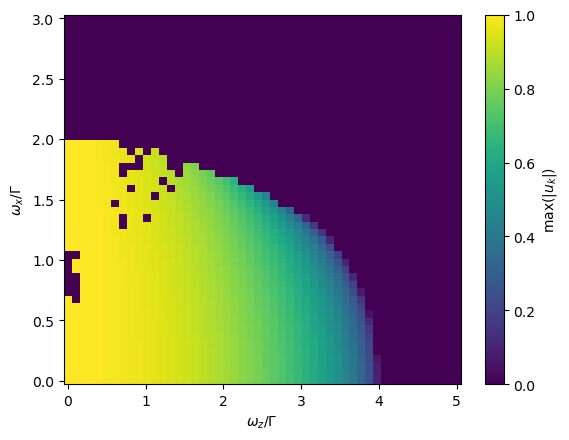

In [66]:
N = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.1
M = np.sqrt(N) * np.log(N)
#M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

us = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(uks_f, x0=np.array([0.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(uks_f, x0=np.array([10.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if uks_f(uks1, wz, ws, np.sqrt(N) * lams, gs, N) < uks_f(uks2, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        us[i, j] = np.amax(np.abs(uks))

plt.pcolormesh(wzs, wxs, us.T, cmap='viridis')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Magnetizations

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_43976/2002650952.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


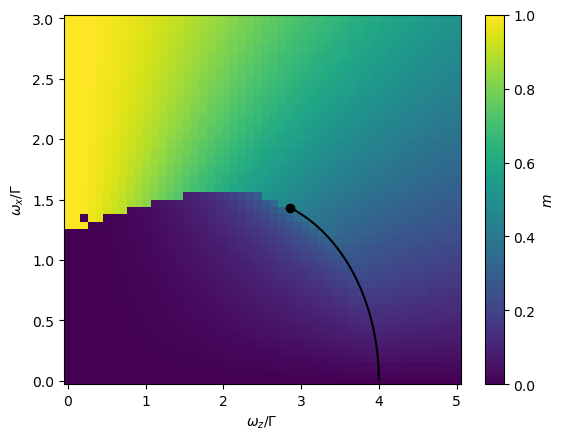

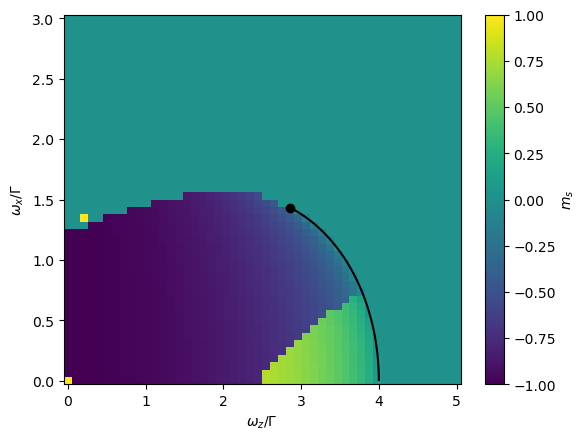

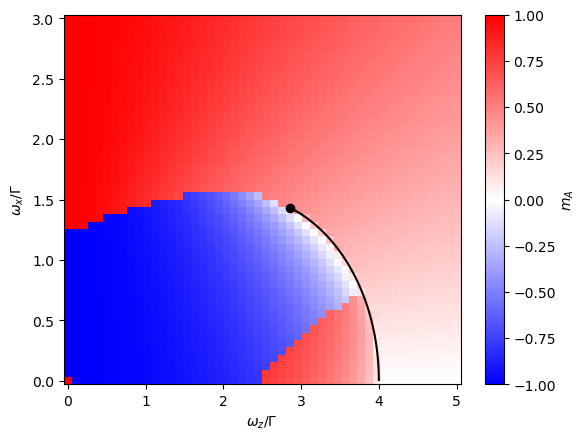

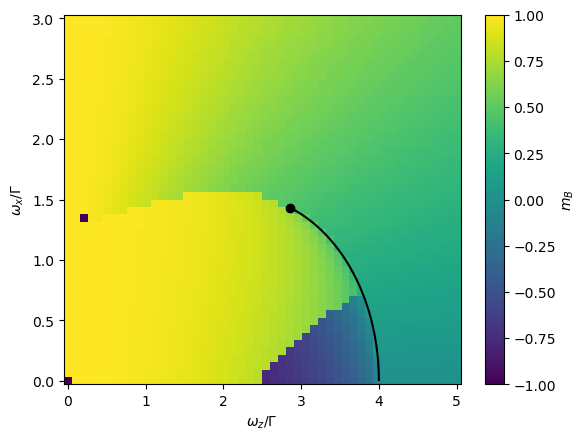

In [67]:

N = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

v_stagger = np.ones(N)
v_stagger[1::2] = -1

mag = np.empty((len(wzs), len(wxs)))
stmag = np.empty((len(wzs), len(wxs)))
magA = np.empty((len(wzs), len(wxs)))
magB = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(uks_f, x0=np.array([0.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(uks_f, x0=np.array([10.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if uks_f(uks1, wz, ws, np.sqrt(N) * lams, gs, N) < uks_f(uks2, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        mags = mags_f(uks, wz, np.sqrt(N) * lams, gs)
        
        mag[i, j] = np.sum(mags) / N
        stmag[i, j] = np.sum(mags * v_stagger) / N
        magA[i, j] = np.sum(mags[::2]) * 2 / N
        magB[i, j] = np.sum(mags[1::2]) * 2 / N

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, mag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, stmag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magA.T, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_A$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magB.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_B$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Check eigenvalues of Hessian

(10, 6)


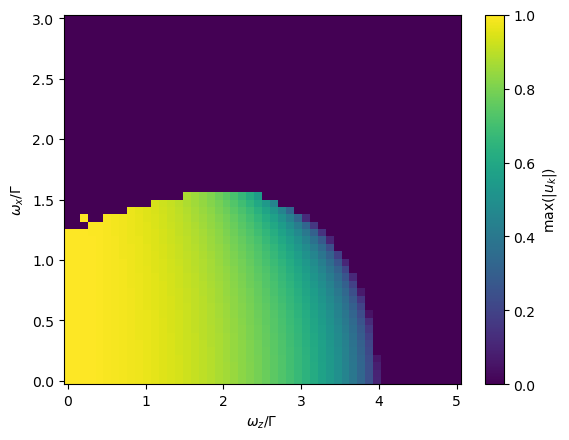

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_43976/2002650952.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


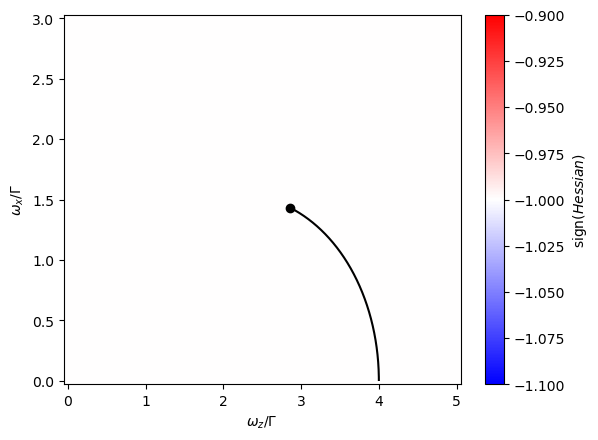

In [68]:
N = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

us = np.empty((len(wzs), len(wxs)))
hessian_sign = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(uks_f, x0=np.array([0.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(uks_f, x0=np.array([10.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if uks_f(uks1, wz, ws, np.sqrt(N) * lams, gs, N) < uks_f(uks2, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        H = hessian(uks, wz, ws, np.sqrt(N) * lams, gs, N)
        vals = eigvalsh(H)
        #print(np.amax(vals))
        #assert np.amax(vals) < 0
            
        us[i, j] = np.amax(np.abs(uks))
        hessian_sign[i, j] = np.amax(vals) / np.abs(np.amax(vals))


plt.pcolormesh(wzs, wxs, us.T, cmap='viridis')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, hessian_sign, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'${\rm sign}(Hessian)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Assume inhomogeneous solution

(10, 6)


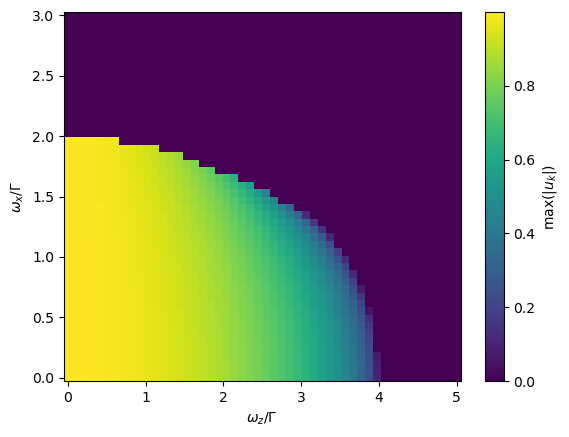

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_43976/2002650952.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


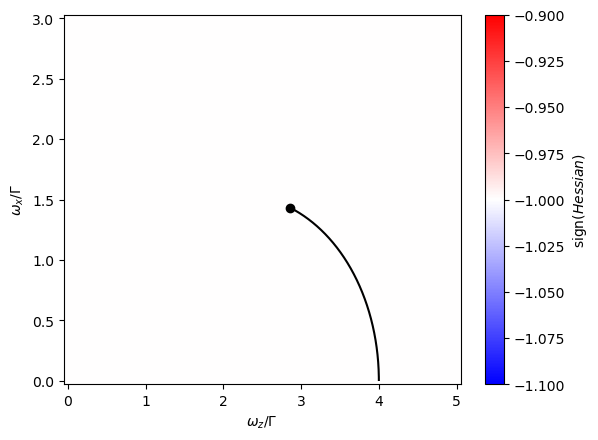

In [69]:
N = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

print(lams.shape)

us_anti = np.empty((len(wzs), len(wxs)))
hessian_sign = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=10.0, args=(wz, 1, gs[0])).x[0]
        
        if uk_f(u1, wz, 1, gs[0]) < uk_f(u2, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        uks = np.zeros(M)
        uks[-1] = u
        H = hessian(uks, wz, ws, np.sqrt(N) * lams, gs, N)
        vals = eigvalsh(H)
        #print(np.amax(vals))
        #assert np.amax(vals) < 0
            
        us_anti[i, j] = np.abs(u)
        hessian_sign[i, j] = np.amax(vals) / np.abs(np.amax(vals))


plt.pcolormesh(wzs, wxs, us_anti.T, cmap='viridis')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, hessian_sign, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'${\rm sign}(Hessian)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Check differences between general solution and solution assuming inhomogeneity

(10, 6)


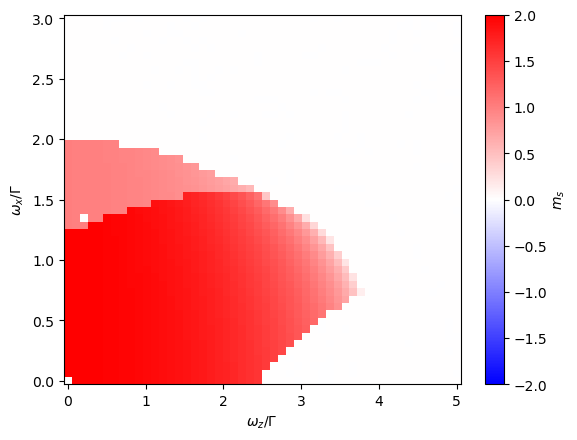

In [70]:
N = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

v_stagger = np.ones(N)
v_stagger[1::2] = -1

mags = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(uks_f, x0=np.array([0.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(uks_f, x0=np.array([10.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if uks_f(uks1, wz, ws, np.sqrt(N) * lams, gs, N) < uks_f(uks2, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        ms = mags_f(uks, wz, np.sqrt(N) * lams, gs)
        mags[i, j] = np.sum(ms * v_stagger) / N
        
mags_anti = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=2.0, args=(wz, 1, gs[0])).x[0]
        
        if uk_f(u1, wz, 1, gs[0]) < uk_f(u2, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        uks = np.zeros(M)
        uks[-1] = u
        ms = mags_f(uks, wz, np.sqrt(N) * lams, gs)
        mags_anti[i, j] = np.sum(ms * v_stagger) / N

plt.pcolormesh(wzs, wxs, mags_anti.T - mags.T, cmap='bwr', vmin=-np.amax(np.abs(mags_anti.T - mags.T)), vmax=np.amax(np.abs(mags_anti.T - mags.T)))
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Basinhopping search around inhomogeneous solution

(10, 9)


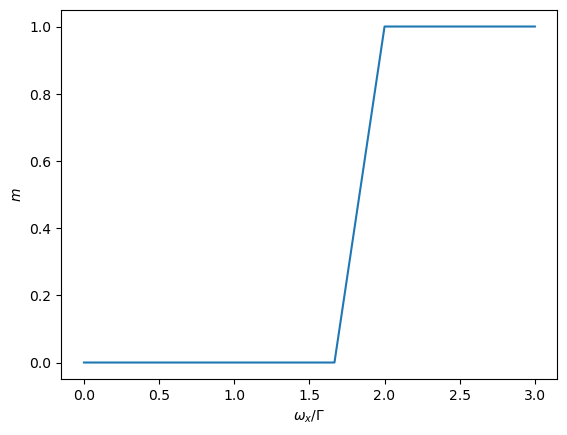

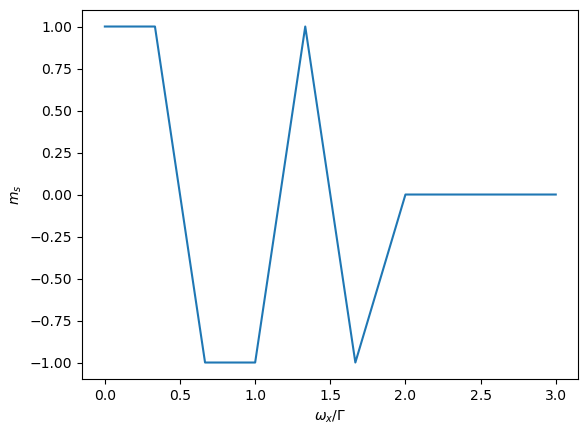

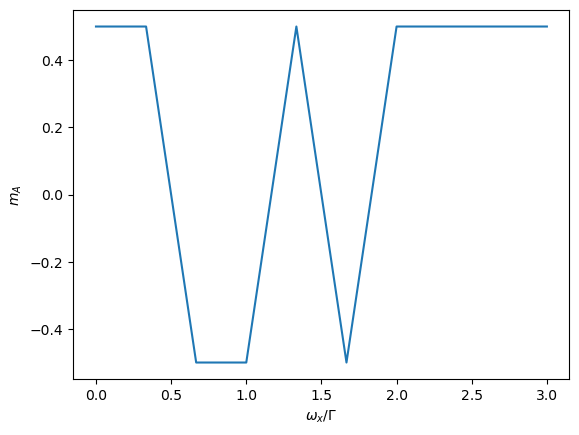

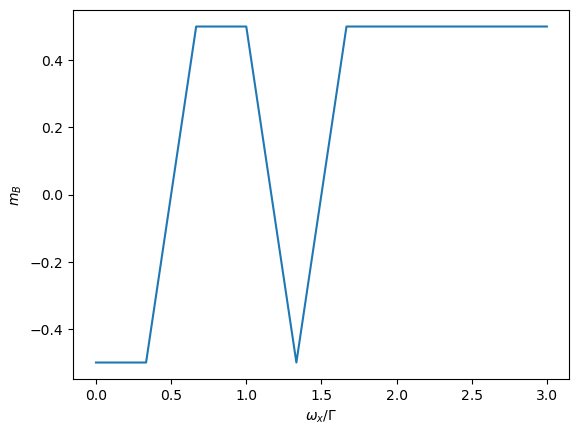

In [95]:
from scipy.optimize import basinhopping

N = 10
wz = 0
wxs = np.linspace(0, 3, 10)
alpha = 0.7
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)
v_stagger = np.ones(N)
v_stagger[1::2] = -1
        
mags = np.empty(len(wxs))
mags_st = np.empty(len(wxs))
mags_A = np.empty(len(wxs))
mags_B = np.empty(len(wxs))
for j, wx in enumerate(wxs):
    gs = wx * np.ones(N) / 2
    uks1 = basinhopping(uks_f, x0=np.array([0.0]*len(ws)), niter=100, minimizer_kwargs={'args': (wz, ws, np.sqrt(N) * lams, gs, N)}).x
    uks2 = basinhopping(uks_f, x0=np.array([10.0]*len(ws)), niter=100, minimizer_kwargs={'args': (wz, ws, np.sqrt(N) * lams, gs, N)}).x
    
    if uks_f(uks1, wz, ws, np.sqrt(N) * lams, gs, N) < uks_f(uks2, wz, ws, np.sqrt(N) * lams, gs, N):
        uks = uks1
    else:
        uks = uks2
    
    ms = mags_f(uks, wz, np.sqrt(N) * lams, gs)
    mags[j] = np.sum(ms) / N
    mags_st[j] = np.sum(ms * v_stagger) / N
    mags_A[j] = np.sum(ms[::2]) / N
    mags_B[j] = np.sum(ms[1::2]) / N
    

plt.plot(wxs, mags)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m$')
plt.show()

plt.plot(wxs, mags_st)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_s$')
plt.show()

plt.plot(wxs, mags_A)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_A$')
plt.show()

plt.plot(wxs, mags_B)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_B$')
plt.show()


# Wipf's order parameter

In [ ]:
from scipy.fft import fft
N = 30
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.7
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

v_stagger = np.ones(N)
v_stagger[1::2] = -1

mag = np.empty((len(wzs), len(wxs)))
stmag = np.empty((len(wzs), len(wxs)))
magA = np.empty((len(wzs), len(wxs)))
magB = np.empty((len(wzs), len(wxs)))
kmaxs = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        gs[0] = wx * 0.00001
        uks1 = minimize(uks_f, x0=np.array([0.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(uks_f, x0=np.array([2.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if uks_f(uks1, wz, ws, np.sqrt(N) * lams, gs, N) < uks_f(uks2, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        mags = mags_f(uks, wz, np.sqrt(N) * lams, gs)
        
        mag[i, j] = np.sum(mags) / N
        stmag[i, j] = np.sum(mags * v_stagger) / N
        magA[i, j] = np.sum(mags[::2]) * 2 / N
        magB[i, j] = np.sum(mags[1::2]) * 2 / N
        
        mus = kernel(uks, np.sqrt(N) * lams, gs * 0)
        plt.plot(mus)
        plt.show()
        Cs = np.array([1/N * np.sum(mus * np.roll(mus, i)) for i in range(N)])
        Cks = fft(Cs)
        kmaxs[i, j] = np.argmax(Cks)
        #kmaxs[i, j] = np.sum(Cs * v_stagger) / N
        
        print(np.sum(mags * v_stagger) / N, np.sum(Cs * v_stagger) / N)
        plt.plot(Cs)
        plt.show()
        plt.plot(Cks)
        plt.show()

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, mag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, np.abs(stmag.T), cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magA.T, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_A$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magB.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_B$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, kmaxs.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$k_{\rm max}$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

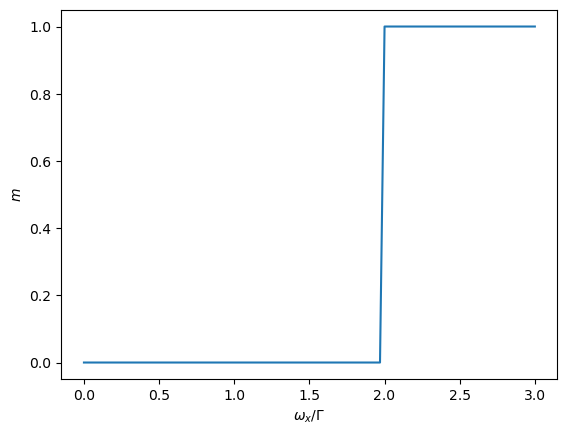

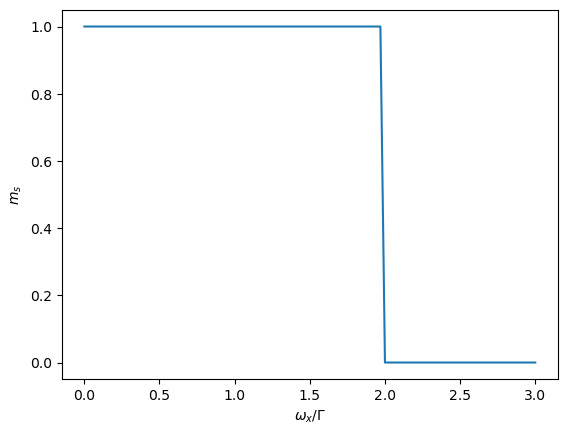

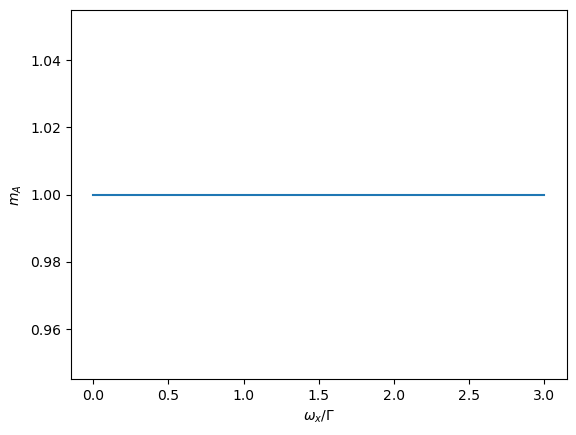

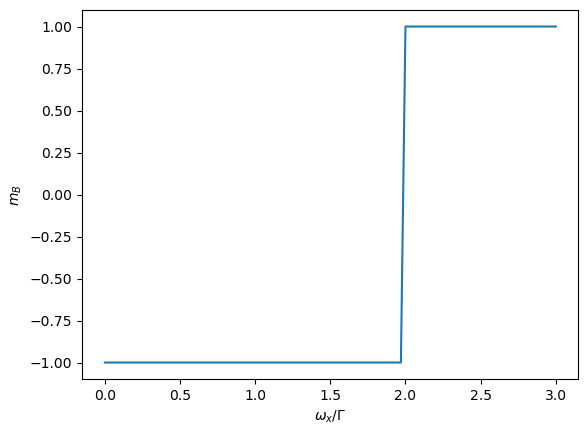

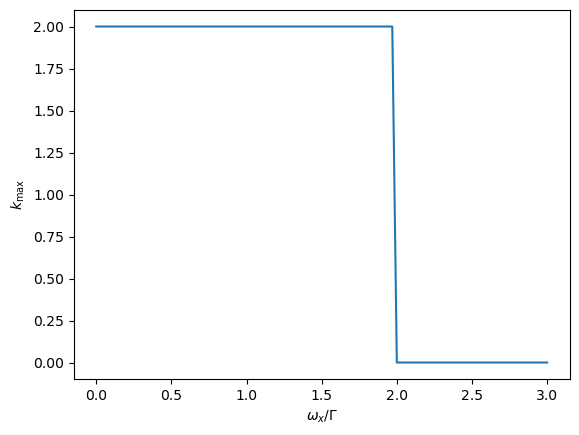

In [74]:
from scipy.fft import fft
N = 30
wz = 0
wxs = np.linspace(0, 3, 100)
alpha = 0.7
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

v_stagger = np.ones(N)
v_stagger[1::2] = -1

mag = np.empty(len(wxs))
stmag = np.empty(len(wxs))
magA = np.empty(len(wxs))
magB = np.empty(len(wxs))
kmaxs = np.empty(len(wxs))
for j, wx in enumerate(wxs):
    gs = wx * np.ones(N) / 2
    uks1 = minimize(uks_f, x0=np.array([0.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
    uks2 = minimize(uks_f, x0=np.array([10.0]*len(ws)), args=(wz, ws, np.sqrt(N) * lams, gs, N)).x
    
    if uks_f(uks1, wz, ws, np.sqrt(N) * lams, gs, N) < uks_f(uks2, wz, ws, np.sqrt(N) * lams, gs, N):
        uks = uks1
    else:
        uks = uks2
        
    mags = mags_f(uks, wz, np.sqrt(N) * lams, gs)
    
    mag[j] = np.sum(mags) / N
    stmag[j] = np.sum(mags * v_stagger) / N
    magA[j] = np.sum(mags[::2]) * 2 / N
    magB[j] = np.sum(mags[1::2]) * 2 / N
    
    mus = kernel(uks, np.sqrt(N) * lams, gs * 0)
    Cs = np.array([1/N * np.sum(mus * np.roll(mus, i)) for i in range(N)])
    Cks = fft(Cs)
    kmaxs[j] = np.argmax(Cks)
    kmaxs[j] = np.sum(mus * v_stagger) / N
    
    # print(np.sum(mags * v_stagger) / N, np.sum(Cs * v_stagger) / N)
    # plt.plot(Cs)
    # plt.show()
    # plt.plot(Cks)
    # plt.show()

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.plot(wxs, mag)
plt.ylabel(r'$m$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()

plt.plot(wxs, np.abs(stmag))
plt.ylabel(r'$m_s$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()

plt.plot(wxs, magA)
plt.ylabel(r'$m_A$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()

plt.plot(wxs, magB)
plt.ylabel(r'$m_B$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()

plt.plot(wxs, kmaxs)
plt.ylabel(r'$k_{\rm max}$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()

# Optimization in terms of magnetizations

In [75]:
def ms_f(ms, wz, J, gs, N):
    aux = 2 * np.dot(J, ms) + gs
    return 1/N*np.dot(ms, np.dot(J, ms)) - 1/N*np.sum(0.5 * np.sqrt(wz**2 + 4*aux**2))

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_43976/2002650952.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


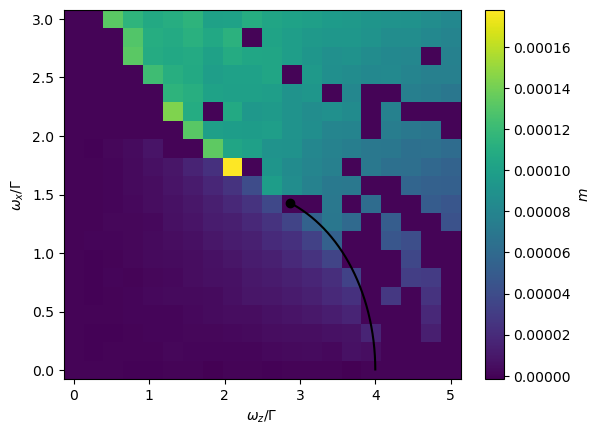

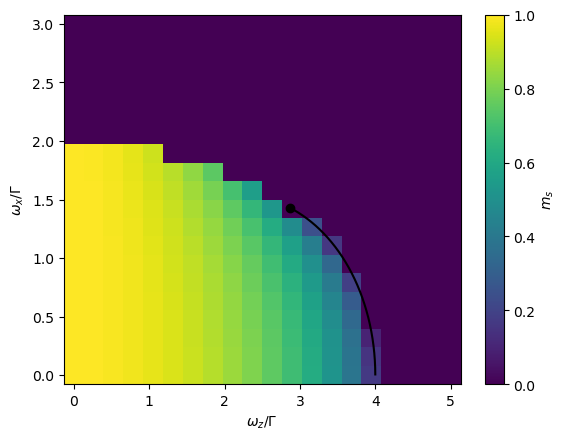

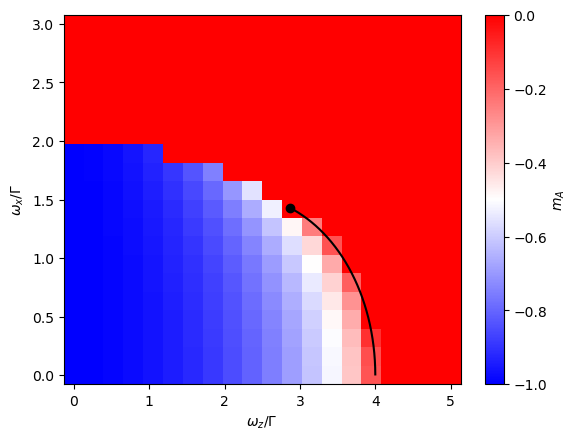

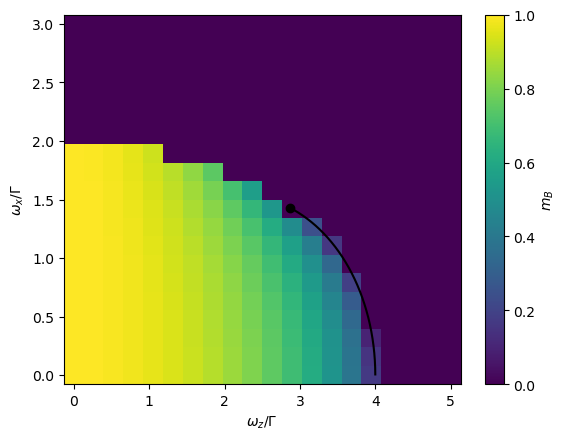

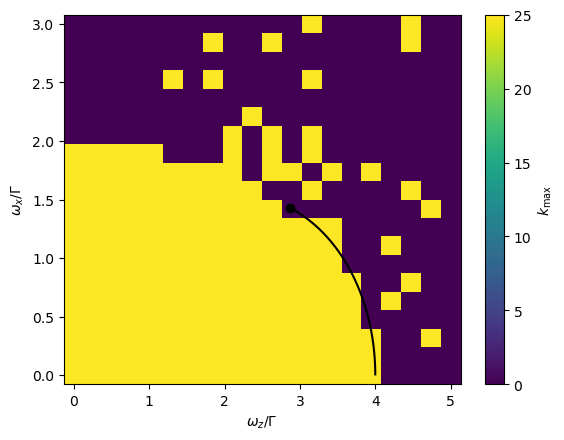

In [94]:

N = 50
wzs = np.linspace(0, 5, 20)
wxs = np.linspace(0, 3, 20)
alpha = 0.5

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)

v_stagger = np.ones(N)
v_stagger[::2] = -1

mag = np.empty((len(wzs), len(wxs)))
stmag = np.empty((len(wzs), len(wxs)))
magA = np.empty((len(wzs), len(wxs)))
magB = np.empty((len(wzs), len(wxs)))
kmaxs = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        ms1 = minimize(ms_f, x0=np.array([0.0]*N), args=(wz, J, gs, N)).x
        ms2 = minimize(ms_f, x0=np.array([1.0]*N)*v_stagger, args=(wz, J, gs, N)).x
        
        if ms_f(ms1, wz, J, gs, N) < ms_f(ms2, wz, J, gs, N):
            ms = ms1
        else:
            ms = ms2
            
        Cs = np.array([1/N * np.sum(ms * np.roll(ms, i)) for i in range(N)])
        Cks = fft(Cs)
        
        kmaxs[i, j] = np.argmax(Cks)
        mag[i, j] = np.sum(ms) / N
        stmag[i, j] = np.sum(ms * v_stagger) / N
        magA[i, j] = np.sum(ms[::2]) * 2 / N
        magB[i, j] = np.sum(ms[1::2]) * 2 / N

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, mag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, stmag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magA.T, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_A$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magB.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_B$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, kmaxs.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$k_{\rm max}$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

(10, 9)


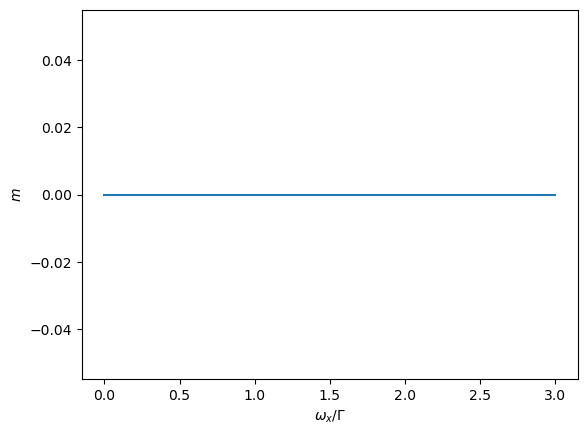

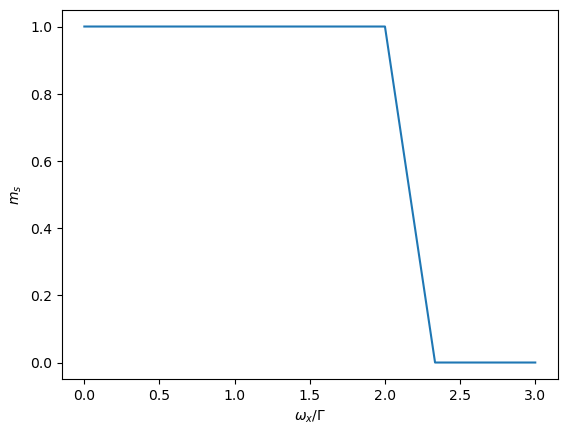

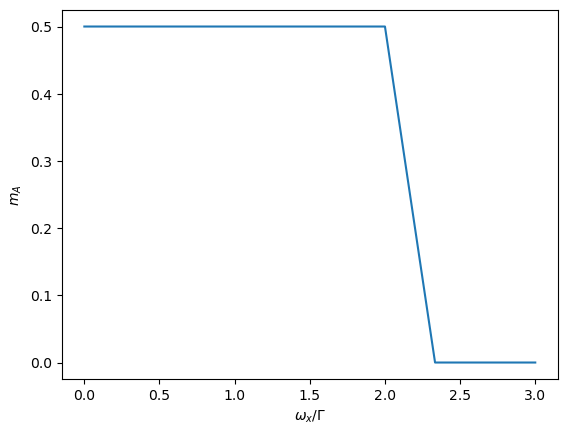

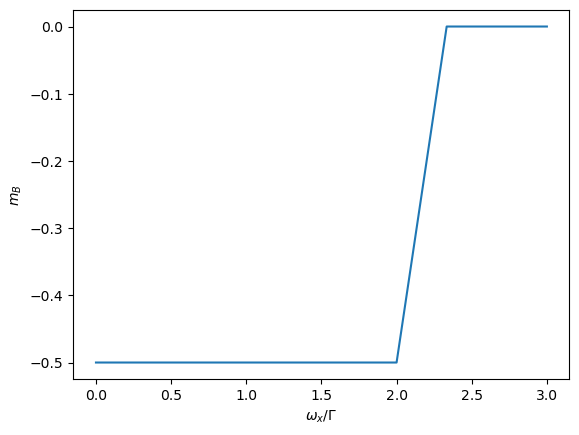

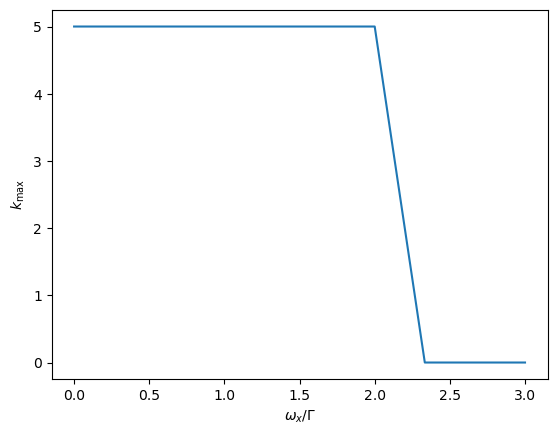

In [98]:
from scipy.optimize import basinhopping

N = 10
wz = 0
wxs = np.linspace(0, 3, 10)
alpha = 0.7

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)

print(lams.shape)
v_stagger = np.ones(N)
v_stagger[1::2] = -1
        
mags = np.empty(len(wxs))
mags_st = np.empty(len(wxs))
mags_A = np.empty(len(wxs))
mags_B = np.empty(len(wxs))
kmaxs = np.empty(len(wxs))
for j, wx in enumerate(wxs):
    gs = wx * np.ones(N) / 2
    ms1 = basinhopping(ms_f, x0=np.array([0.0]*N), niter=100, minimizer_kwargs={'args': (wz, J, gs, N)}).x
    ms2 = basinhopping(ms_f, x0=np.array([1.0]*N)*v_stagger, niter=100, minimizer_kwargs={'args': (wz, J, gs, N)}).x
    
    if ms_f(ms1, wz, J, gs, N) < ms_f(ms2, wz, J, gs, N):
        ms = ms1
    else:
        ms = ms2
        
    Cs = np.array([1/N * np.sum(ms * np.roll(ms, i)) for i in range(N)])
    Cks = fft(Cs)

    kmaxs[j] = np.argmax(Cks)
    mags[j] = np.sum(ms) / N
    mags_st[j] = np.sum(ms * v_stagger) / N
    mags_A[j] = np.sum(ms[::2]) / N
    mags_B[j] = np.sum(ms[1::2]) / N
    

plt.plot(wxs, mags)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m$')
plt.show()

plt.plot(wxs, mags_st)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_s$')
plt.show()

plt.plot(wxs, mags_A)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_A$')
plt.show()

plt.plot(wxs, mags_B)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_B$')
plt.show()

plt.plot(wxs, kmaxs)
plt.ylabel(r'$k_{\rm max}$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()


# Educated guess

(10, 9)


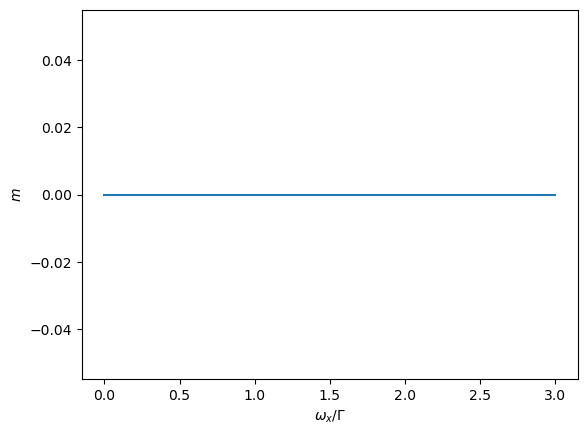

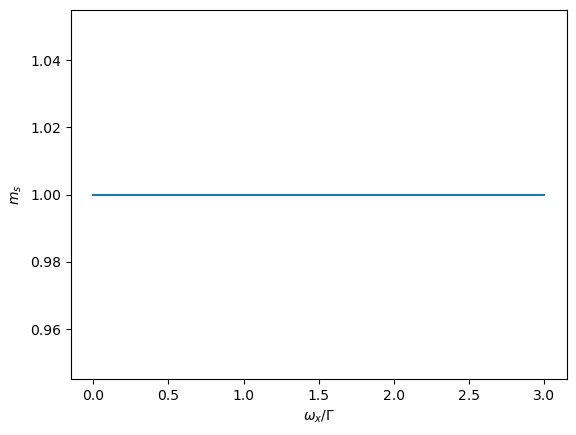

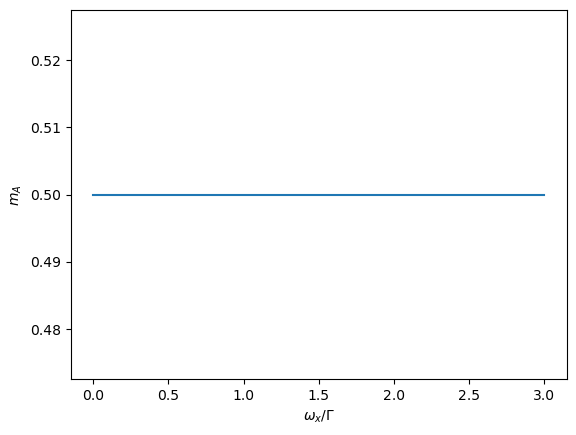

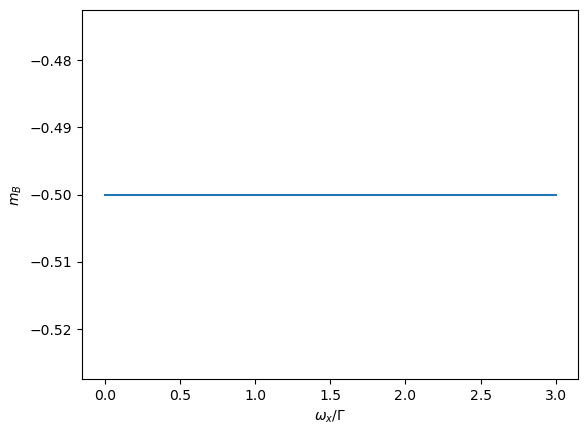

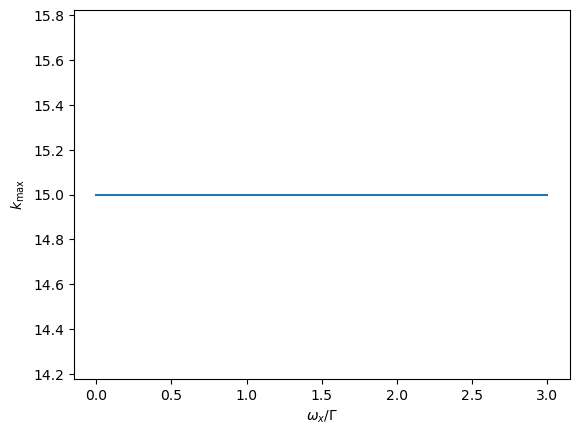

In [120]:
from scipy.optimize import basinhopping

N = 30
wz = 0
wxs = np.linspace(0, 3, 10)
alpha = 0.7

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)

print(lams.shape)
v_stagger = np.ones(N)
v_stagger[1::2] = -1
        
mags = np.empty(len(wxs))
mags_st = np.empty(len(wxs))
mags_A = np.empty(len(wxs))
mags_B = np.empty(len(wxs))
kmaxs = np.empty(len(wxs))
for j, wx in enumerate(wxs):
    gs = wx * np.ones(N) / 2
    k = N // 2
    amp = 1
    initial_condition = amp * np.cos(2*np.pi * np.arange(N) * k / N)
    ms1 = basinhopping(ms_f, x0=np.array([1.0]*N) * v_stagger, niter=100, minimizer_kwargs={'args': (wz, J, gs, N)}).x
    ms2 = basinhopping(ms_f, x0=initial_condition, niter=100, minimizer_kwargs={'args': (wz, J, gs, N)}).x
    
    if ms_f(ms1, wz, J, gs, N) < ms_f(ms2, wz, J, gs, N):
        ms = ms1
    else:
        ms = ms2
        
    Cs = np.array([1/N * np.sum(ms * np.roll(ms, i)) for i in range(N)])
    Cks = fft(Cs)

    kmaxs[j] = np.argmax(Cks)
    mags[j] = np.sum(ms) / N
    mags_st[j] = np.sum(ms * v_stagger) / N
    mags_A[j] = np.sum(ms[::2]) / N
    mags_B[j] = np.sum(ms[1::2]) / N
    

plt.plot(wxs, mags)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m$')
plt.show()

plt.plot(wxs, mags_st)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_s$')
plt.show()

plt.plot(wxs, mags_A)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_A$')
plt.show()

plt.plot(wxs, mags_B)
plt.xlabel(r'$\omega_x/\Gamma$')
plt.ylabel(r'$m_B$')
plt.show()

plt.plot(wxs, kmaxs)
plt.ylabel(r'$k_{\rm max}$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()


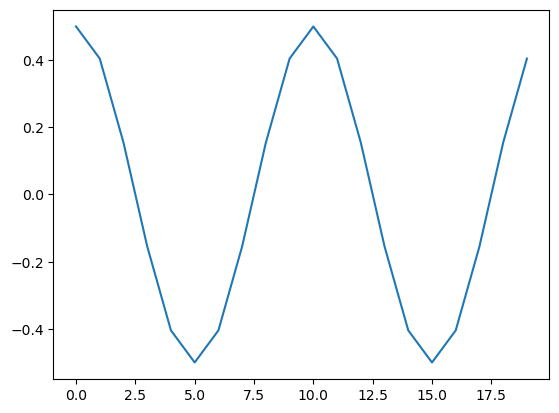

In [116]:
N = 20

k = 2
amp = 0.5
initial_condition = amp * np.cos(2*np.pi * np.arange(N) * k / N)
plt.plot(initial_condition)
plt.show()

# Test of correlation matrix

u = 0.9614007824213392


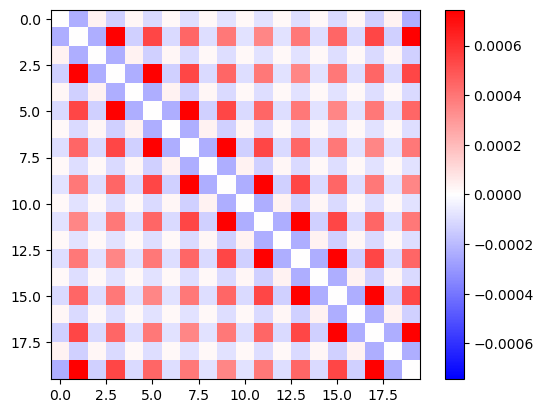

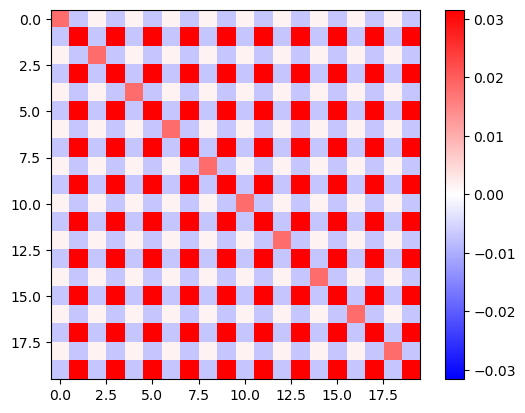

[[ 1.09394633 30.60928376 42.40981313 51.29246387 58.67716218 65.1236252
  70.89570759 76.15891251 80.99016295 85.46120523 89.52792548 85.46120523
  80.99016295 76.15891251 70.89570759 65.1236252  58.67716218 51.29246387
  42.40981313 30.60928376]
 [30.60928376  1.40928011 30.60928376 42.42259036 51.29246387 58.68145428
  65.1236252  70.90124759 76.15891251 81.00346602 85.46120523 89.57876606
  85.46120523 81.00346602 76.15891251 70.90124759 65.1236252  58.68145428
  51.29246387 42.42259036]
 [42.40981313 30.60928376  1.09394633 30.60928376 42.40981313 51.29246387
  58.67716218 65.1236252  70.89570759 76.15891251 80.99016295 85.46120523
  89.52792548 85.46120523 80.99016295 76.15891251 70.89570759 65.1236252
  58.67716218 51.29246387]
 [51.29246387 42.42259036 30.60928376  1.40928011 30.60928376 42.42259036
  51.29246387 58.68145428 65.1236252  70.90124759 76.15891251 81.00346602
  85.46120523 89.57876606 85.46120523 81.00346602 76.15891251 70.90124759
  65.1236252  58.68145428]
 [58.6

In [13]:
N = 20
wx = 0.5
wz = 0.5
G = 1
s = 1
alpha = 0.5

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)

u = variational_u(G, wx, wz, s)
print(f'u = {u}')
Ys = np.array([f_Yi(i, u, G, wx, wz, s) for i in range(N)])
Dy = np.diag(Ys)

chi = inv(np.eye(N) - 2*Dy@J) @ Dy
max = np.amax(np.abs(chi) - np.diag(np.diag(chi)))
plt.imshow(chi - np.diag(np.diag(chi)), vmin=-max, vmax=max, cmap='bwr')
plt.colorbar()
plt.show()

chi_theo = np.empty((N, N))
for idx, _ in np.ndenumerate(chi_theo):
    chi_theo[idx] = chi_theo_ij(*idx, Ys[0], Ys[1], G)
chi_theo = chi_theo
max = np.amax(np.abs(chi_theo) - np.diag(np.diag(chi_theo)))
plt.imshow(chi_theo, vmin=-max, vmax=max, cmap='bwr')
plt.colorbar()
plt.show()

print(chi_theo / chi)

print(chi_theo[1, 0] / chi_theo[0, 0], -G*(Ys[0] + Ys[1])*Ys[1]/Ys[0])